In [ ]:
!pip install osmnx
!pip install contextily
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 38.2 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.5 MB/s eta 0:00:00


In [ ]:
from shapely.geometry import Point, LineString, Polygon, LinearRing, GeometryCollection
import geopandas as gpd
import osmnx
import pyproj
import pandas as pd
import contextily as ctx
from matplotlib import pyplot as plt
import numpy as np
from shapely.ops import polygonize, unary_union
from io import BytesIO
import requests
import rasterio
from rasterio.mask import mask as raster_mask
from rasterio.plot import show as show_raster

In [ ]:
crs_gps = pyproj.CRS.from_epsg('4326')
crs_web = pyproj.CRS.from_epsg('3857')
crs_dem = pyproj.CRS.from_epsg('3301')
map_source = ctx.providers.OpenStreetMap.Mapnik

## Districts in Tartu

In [ ]:
gdf_tartu = osmnx.features_from_place('Tartu linn',tags={'name': 'Tartu linn','alt_name': 'Tartu','type': 'boundary', 'boundary': 'administrative','admin_level': '9'})


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

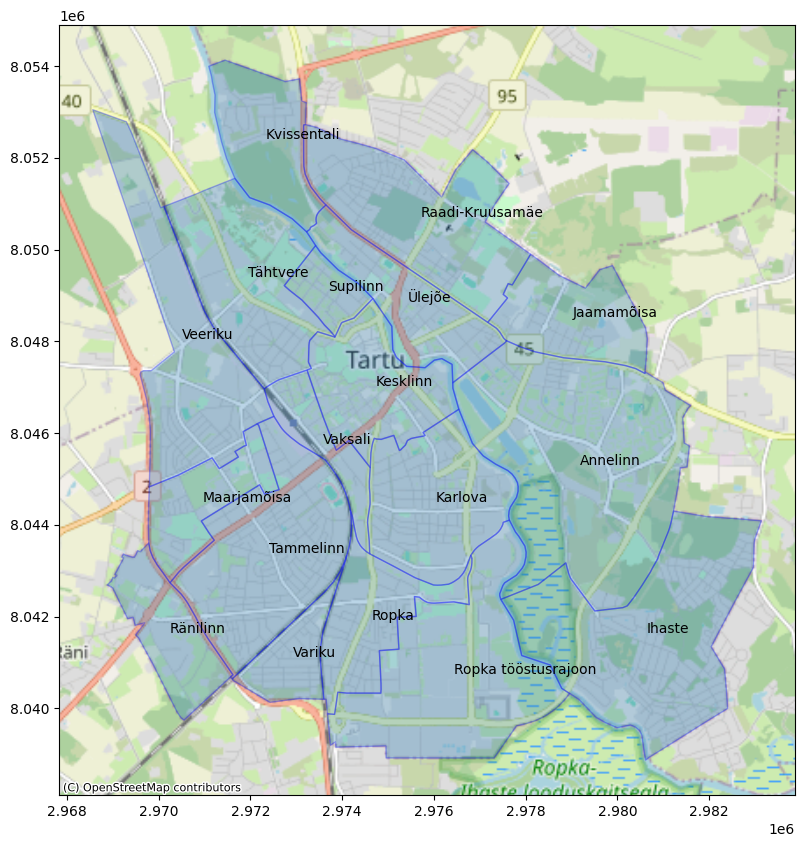

In [ ]:
gdf_tartu_areas = gdf_tartu \
                        .reset_index() \
                        .set_index(['element_type','place','osmid']) \
                        .loc['relation'] \
                            .loc['quarter'] \
                        .to_crs(crs=crs_web)


ax = gdf_tartu_areas.plot(edgecolor='blue', alpha=.3, figsize=(10, 10))

for rel in gdf_tartu_areas.index:
    lon,lat = np.asarray(gdf_tartu_areas.centroid.loc[rel].xy)
    ax.text(x=lon,y=lat,s=gdf_tartu_areas.loc[rel]['name'])

ctx.add_basemap(ax=ax, source=map_source, zoom=12)

## Average elevation for Estonia and Tartu districts

In [ ]:
# Download and read elevation info
geoportaal_url = 'https://geoportaal.maaamet.ee/index.php?lang_id=2&plugin_act=otsing&andmetyyp=mp_korgusmudelid&dl=1&f=DTM_25m_eesti.tif&page_id=664'

fd = BytesIO()
req = requests.get(geoportaal_url, stream=True)
for chunk in req.iter_content(chunk_size=1024**2):
    if chunk:
        fd.write(chunk)
fd.seek(0)

dem_25m_eesti = rasterio.open(fd)
dem_25m_eesti

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<open DatasetReader name='/vsimem/c236c299-69e3-4564-b90f-5906eb6c87db/c236c299-69e3-4564-b90f-5906eb6c87db.tif' mode='r'>

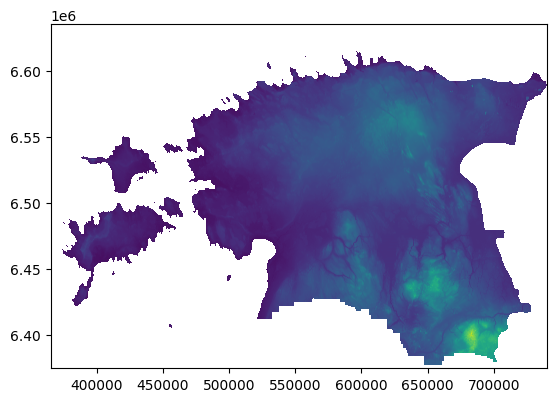

<Axes: >

In [ ]:
show_raster(dem_25m_eesti)

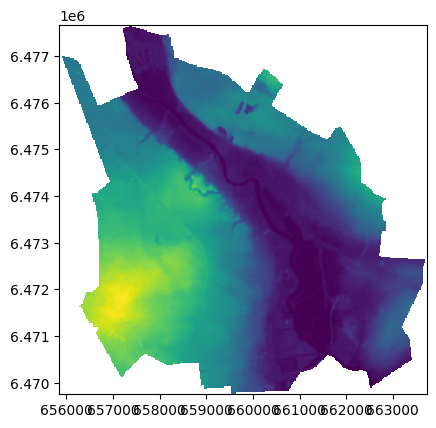

<Axes: >

In [ ]:
tartu_outer_border = unary_union(GeometryCollection(list(gdf_tartu_areas.geometry)))

gdf_tartu_boundary = gpd.GeoDataFrame({'geometry':[tartu_outer_border]}, crs=crs_web)
gdf_tartu_boundary.to_crs(crs_dem)


# Mask the elevation data using Tartu boundary
out_img, out_transform = raster_mask(dem_25m_eesti,
                                     shapes=list(gdf_tartu_boundary.to_crs(crs=crs_dem).geometry),
                                     crop=True)
out_meta = dem_25m_eesti.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform})
out_buffer = BytesIO()
with rasterio.open(out_buffer, 'w', **out_meta) as _fd:
    _fd.write(out_img)
out_buffer.seek(0)

dem_25m_tartu = rasterio.open(out_buffer)
show_raster(dem_25m_tartu)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

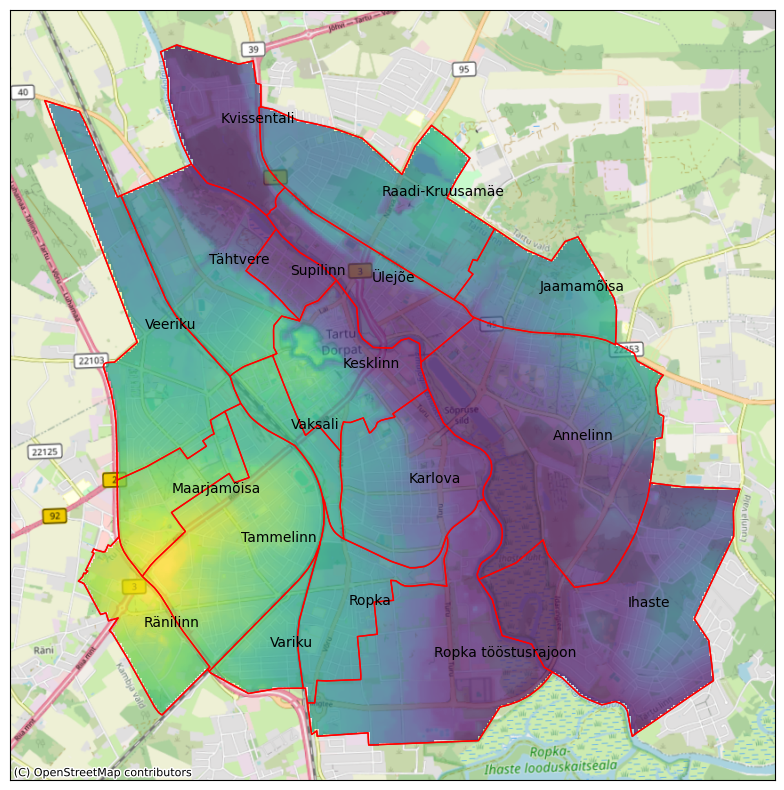

In [ ]:
# Plot districts and elevation map
fig, ax = plt.subplots(1,1, figsize=(10,10))

# plot districts
gdf_tartu_areas.to_crs(crs_dem).plot(ax=ax, edgecolor='red', facecolor='none')

# add labels
for rel in gdf_tartu_areas.index:
    lon,lat = np.hstack(gdf_tartu_areas.centroid.to_crs(crs=crs_dem).loc[rel].xy)
    label = gdf_tartu_areas.loc[rel]['name']
    ax.text(x=lon, y=lat, s=label)

# plot boundary
gpd.GeoDataFrame({'geometry':[tartu_outer_border]},crs=crs_web).to_crs(crs=crs_dem)\
    .plot(ax=ax, edgecolor='red', facecolor='none')

# set axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# add basemap
ctx.add_basemap(ax=ax, crs=crs_dem, source=ctx.providers.OpenStreetMap.DE)

# add DEM layer
show_raster(dem_25m_tartu, ax=ax, alpha=0.7)

## Road graph of Tartu

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


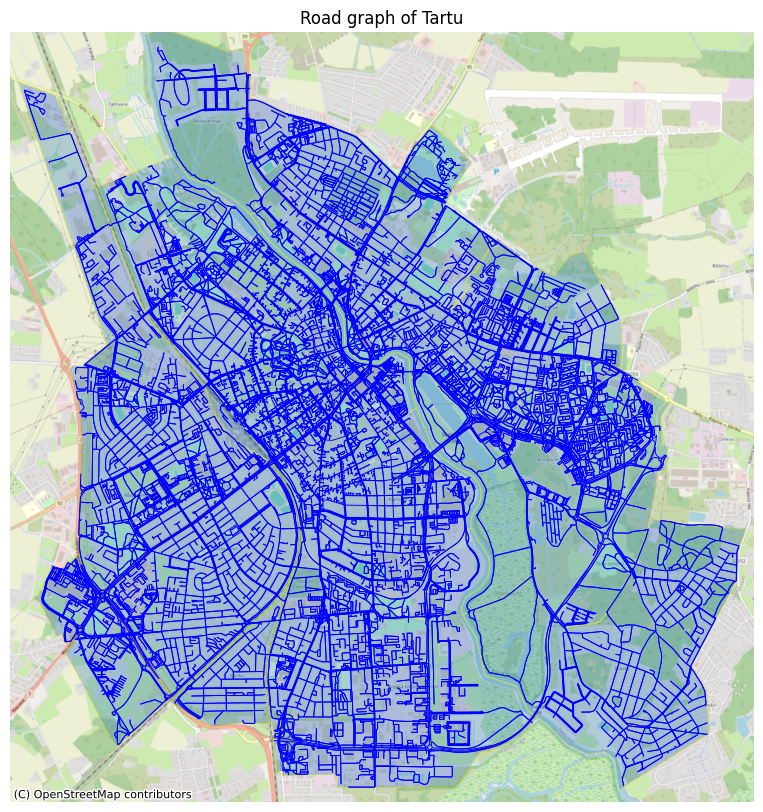

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Road graph of Tartu'}>)

In [ ]:
tartu_boundary_crs_gps = unary_union(list(gdf_tartu_boundary.to_crs(crs=crs_gps).geometry))
tartu_graph = osmnx.graph_from_polygon(tartu_boundary_crs_gps)

ax = gdf_tartu_areas.to_crs(crs=crs_gps).plot(edgecolor='yellow', alpha=.3, figsize=(10,10))
ax.set_title('Road graph of Tartu')
ctx.add_basemap(ax=ax, crs=crs_gps, source=map_source, zoom=14)
osmnx.plot_graph(tartu_graph, ax=ax, bgcolor='none', node_color='none', node_size=1,
                 edge_color='blue', edge_linewidth=.7)

## Shortest path calculation

In [ ]:
gdf_laulupeo = osmnx.geocode_to_gdf('Laulupeo pst 25, Tartu, Estonia')
gdf_sobra = osmnx.geocode_to_gdf('Sõbra 58, Tartu, Estonia')

gdf_start_stop = gpd.GeoDataFrame(pd.concat([gdf_laulupeo, gdf_sobra])) \
    .assign(label=['laulupeo', 'ropka'], path=['start', 'stop']) \
    .set_index('path') \
    .to_crs(crs=crs_web)

# Extract the coordinate of the corresponding building centroids
lons, lats= np.vstack(gdf_start_stop.geometry.centroid.to_crs(crs=crs_gps) \
                      .apply(lambda gdf: np.asarray(gdf.xy).reshape(-1)).values).T
start, stop = osmnx.nearest_nodes(tartu_graph, lons, lats)
route = osmnx.shortest_path(tartu_graph, start, stop)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


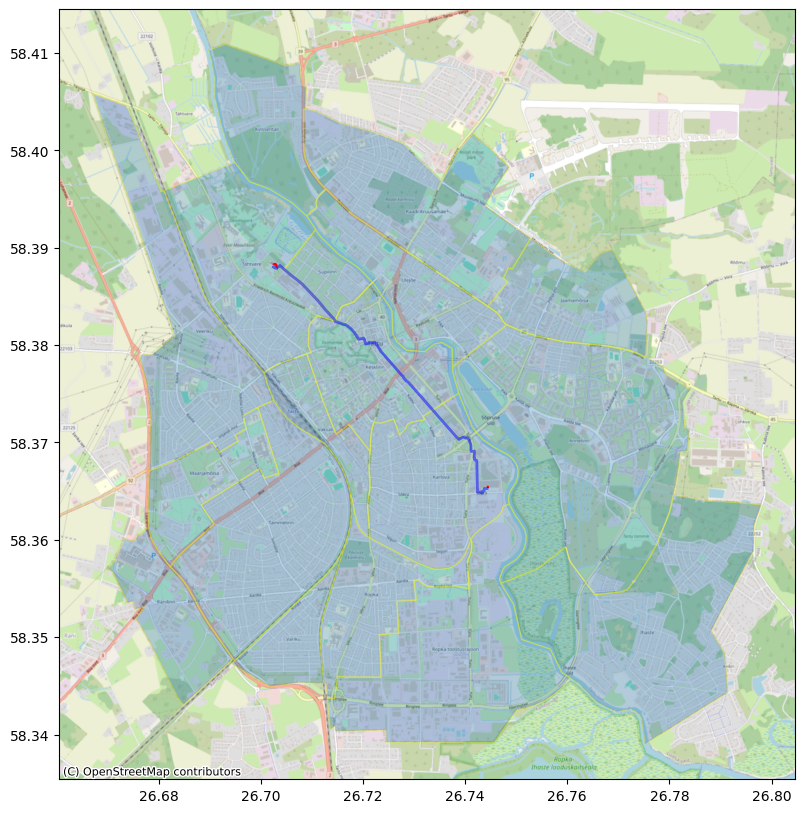

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [ ]:
ax = gdf_tartu_areas.to_crs(crs=crs_gps).plot(edgecolor='yellow', alpha=.3, figsize=(10,10))
gdf_start_stop.to_crs(crs=crs_gps).plot(ax=ax, facecolor='red')
ctx.add_basemap(ax=ax, crs=crs_gps, source=map_source, zoom=14)
osmnx.plot_graph_route(tartu_graph, ax=ax, route=route, bgcolor='none', node_color='none', node_size=0,
                       edge_color='none', edge_linewidth=0, route_color='blue', orig_dest_size=0,
                       route_linewidth=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
